### TODO:


#### dodataki:

Tutoriale:

* https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/
* https://www.kaggle.com/uciml/adult-census-income/notebooks


Dane:

* https://archive.ics.uci.edu/ml/datasets/Adult

Co to są *pipelines* w sci-kit learn i jak je wykorzystać?
Czyli **bardziej efektywne szukanie najlepszego modelu**.

Jeśli zajmujesz się tworzeniem modeli na przykład klasyfikujących jakieś dane to pewnie wielokrotnie powtarzasz te same kroki:

* wczytanie danych
* oczyszczenie danych
* uzupeńienie braków
* przygotowanie dodatkowych cech (feature engineering)
* podział danych na treningowe i testowe
* dobór hyperparametrów modelu
* testowanie modelu

I tak w kółko, z każdym nowy modelem.

Jest to dość nudne i dość powtarzalne. Szczególnie jak trzeba wykonać różne kroki transformacji danych w różnej kolejności - *upierdliwe* staje się zmienianie kolejności w kodzie.

Dlatego wymyślono **pipelines**.

Dlatego w tym i kolejnych postach zajmiemy się tym mechanizmem.

Zaczniemy od podstaaw *data science*, czyli...

In [1]:
# bez tego nie ma data science! ;)
import pandas as pd

# być może coś narysujemy
import matplotlib.pyplot as plt
import seaborn as sns

import time

Wszystkie elementy jakich będziemy używać znajdują się w ramach biblioteki **scikit-learn**. Zaimportujemy co trzeba plus kilka innych modeli.

In [2]:
from sklearn.model_selection import train_test_split

# modele
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# preprocessing
## zmienne ciągłe
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
## zmienne kategoryczne
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# dodatkowe modele spoza sklearn
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Skąd wziąć dane? Można użyć wbudowanych w sklearna irysów czy boston housing ale mi zależało na znalezieniu takiego datasetu, który będzie zawierał cechy zarówno ciągłe jak i kategoryczne. Takim zestawem jest **Adult** znany też jako **Census Income**, a ściągnąć go można z [UCI](https://archive.ics.uci.edu/ml/datasets/Adult). Pobieramy (potrzebne nam będą pliki [adult.data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data) oraz [adult.test](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test)) dane, wrzucamy do katalogu *data/* i wczytujemy.

In [3]:
# dane nie mają nagłówka - samo sobie nadamy nazwy kolumn
col_names= ['age', 'work_class', 'final_weight', 'education', 'education_num',
            'marital_status', 'occupation', 'relationship', 'race', 'sex',
            'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
            'target']

# wczytujemy dane
adult_dataset = pd.read_csv("data/adult.data",
                            engine='python', sep=', ', # tu jest przeciek i spacja!
                            header=None, names=col_names,
                            na_values="?")

# kolumna 'final_weight' do niczego się nie przyda, więc od razu ją usuwamy
# wiadomo to z EDA, które tutaj pomijamy
adult_dataset.drop('final_weight', axis=1, inplace=True)

# usuwamy braki, żeby uprościć przykład
adult_dataset.dropna(inplace=True)

Zobaczmy jakie mamy typy danych w kolumnach:

In [4]:
adult_dataset.dtypes

age                int64
work_class        object
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
target            object
dtype: object

A teraz standardowo - dzielimy dane na zbiór treningowy i testowy. Przy okazji z całej ramki danych wyciągamy kolumnę `target` jako **Y**, a resztę jako **X**. Szalenie wygodnym jest nazywanie cech zmienną **X** a *targetów* **Y** - przy *Ctrl-C + Ctrl-V* ze StackOverflow niczego właściwie nie trzeba robić ;)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(adult_dataset.drop('target', axis=1),
                                                    adult_dataset['target'],
                                                    test_size=0.3,
                                                    random_state=42)

Sporą część wstępnej analizy pomijam w tym wpisie, ale jeśli nie wiesz dlaczego wybieram takie a nie inne kolumny to zrób samodzielnie analizę danych w tym zbiorze. 

Czas na trochę informacji o *rurociągach*.

W dużym uproszszczeniu są to połączone sekwencyjnie (jedna za drugą, wyjście pierwszej trafia na wejście drugiej i tak dalej do końca) operacje. Operacje czyli klasy, które posiadają metody `.fit()` i `.transform()` - ostatni krok musi mieć .fit (bo to *model* który uczymy),  wszystkie wcześniejsze - .transform (bo to kolejne transformacje danych).

Rurociąg może składać się z kilku rurociągów połączonych jeden za drugim - taki model zastosujemy za chwilę.

Zatem pierwszy krok to przygotowanie danych - odpowiednie transformacje danych źródłowych i ewentualnie uzupełnienie danych brakujących. W dzisiejszym przkładzie brakujące dane (około 7% całości) po prostu wyrzuciliśmy przez `dropna()`, więc uzupełnieniem braków się nie zajmujemy.

Drugim krokiem jest przesłanie danych odpowiednio obrobionych do modelu i jego wytrenowanie.

Przygotujemy sobie fragmenty całego *rurociągu* odpowiedzialnego za transformacje kolumn. Mamy dwa typy kolumn, zatem zbudujemy dwa małe rurociągi.

Pierwszy będzie odpowiedzialny za kolumny z wartościami liczbowymi. Nie wiemy czy są to wartości ciągłe (jak na przykład wiek) czy dyskretne (tutaj taką kolumną jest `education_num` mówiąca o poziome edukacji) i poniżej bierzemy wszystkie jak leci. Znowu: porządna EDA wskaże nam odpowiednie kolumny.

Najpierw wybieramy wszystkie kolumny o typie numerycznym, a potem budujemy mini-rurociąg `transformer_numerical`, którego jedynym krokiem będzie wywołanie `StandardScaler()` zapisane pod nazwą `num_trans` (to musi być unikalne w całym procesie). Kolejny krok łatwo dodać - po prostu dodajemy kolejnego *tupla* w takim samym schemacie.

**Co nam to daje?** Ano daje to tyle, że mamy konkretną nazwę dla konkretnego kroku. Później możemy się do niej dostać i na przykład zmienić: zarówno metodę wywoływaną w tym konkretnym kroku jak i parametry tej metody.

In [9]:
# lista kolumn numerycznych
cols_numerical = X_train.select_dtypes(include=['int64', 'float64']).columns

# transformer dla kolumn numerycznych
transformer_numerical = Pipeline(steps = [
    ('num_trans', StandardScaler())
])

To samo robimy dla kolumn z wartościami kategorycznymi - budujemy mini-rurociąg `transformer_categorical`, który w kroku `cat_trans` wywołuje `OneHotEncoder()`.

In [10]:
# lista kolmn kategorycznych
cols_categorical = ['work_class', 'education', 'marital_status', 'occupation',
                    'relationship', 'race', 'sex', 'native_country']

# transformer dla kolumn numerycznych
transformer_categorical = Pipeline(steps = [
    ('cat_trans', OneHotEncoder())
])

Co dalej? Z tych dwóch małych rurociągów zbudujemy większy - `preprocessor`. Właściwie to będzie to swego rodzaju rozgałęzienie - **ColumnTransformer** który jedne kolumny puści jednym mini-rurociągiem, a drugie - drugim. I znowu: tutaj może być kilka elementów, oddzielne *przepływy* dla konkretnych kolumn (bo może jedne ciągłe chcemy skalować w jeden sposób, a inne w inny? A może jedne zmienne chcemy uzupełnić średnią a inne medianą?) - mamy pełną swobodę.

In [11]:
# preprocesor danych
preprocessor = ColumnTransformer(transformers = [
    ('numerical', transformer_numerical, cols_numerical),
    ('categorical', transformer_categorical, cols_categorical)
])

Cała rura to złożenie odpowiednich elementów w całość - robiliśmy to już wyżej:

In [12]:
pipe = Pipeline(steps = [
                ('preprocessor', preprocessor),
                ('classifier', RandomForestClassifier())
            ])


Teraz cały proces wygląda następująco:

* najpierw preprocessing:
    * dla kolumn liczbowych wykonywany jest `StandardScaler()`
    * dla kolumn kategorycznych - `OneHotEncoder()`
* złożone dane przekazywane są do `RandomForestClassifier()`

 
 Proces trenuje się dokładne tak samo jak model:

In [13]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('num_trans',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_wee...
                 RandomForestClassifier(bo

a po wytrenowaniu na danych treningowych (cechy *X_train*, target *y_train*) możemy zobaczyć ocenę modelu na danych testowych (odpowiednio *X_test* i *y_test*)

In [14]:
pipe.score(X_test, y_test)

0.8427450547021771

Świetnie, świetne, ale to samo można bez tych pipelinów, nie raz na Kaggle tak robili i działało. Więc **po co to wszystko?**

Ano po to, co nastąpi za chwilę.

Mamy cały proces, każdy jego krok ma swoją nazwę, prawda? A może zamiast *StandardScaler()* lepszy będzie *MinMaxScaler()*? A może inna klasa modeli (zamiast lasów losowych np. XGBoost?). A gdyby sprawdzić każdy model z każdą transformacją? No to się robi sporo kodu... A nazwane kroki w procesie pozwalają na prostą podmiankę!

Zdefiniujmy sobie przestrzeń poszukiwań nalepszego modelu i najlepszych transformacji:

In [19]:
# klasyfikatory                            
classifiers = [
    KNeighborsClassifier(2), # 2 bo mamy dwie klasy
    ExtraTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    XGBClassifier(),
    CatBoostClassifier(silent=True),
    LGBMClassifier(verbose=-1)
]

# transformatory dla kolumn liczbowych
scalers = [StandardScaler(), MinMaxScaler(), Normalizer()]

# transformatory dla kolumn kategorycznych
cat_transformers = [OrdinalEncoder(), OneHotEncoder()]

Teraz w zagnieżdżonych pętlach możemy sprawdzić *każdy z każdym* podmieniając klasyfikatory i transformatory (cała pętla trochę się kręci):

In [20]:
# miejsce na zebranie wyników
models_df = pd.DataFrame()

# dla każdego typu modelu zmieniamy kolejne transformatory kolumn
for model in classifiers:
    for num_tr in scalers:
        for cat_tr in cat_transformers:

            # przygotowujemy pipeline
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])

            # odpowiednio zmieniamy jego paramety - dobieramy transformatory
            pipe_params = {
                'preprocessor__numerical__num_trans': num_tr,
                'preprocessor__categorical__cat_trans': cat_tr
            }

            pipe.set_params(**pipe_params)

            print('='*40)

            # trenujemy tak przygotowany model (cały pipeline) mierząc ile to trwa
            start_time = time.time()
            pipe.fit(X_train, y_train)   
            end_time = time.time()

            # sprawdzamy jak wyszło
            score = pipe.score(X_test, y_test)

            # zbieramy w dict parametry
            param_dict = {
                        'model': model.__class__.__name__,
                        'num_trans': num_tr.__class__.__name__,
                        'cat_trans': cat_tr.__class__.__name__,
                        'score': round(100*score, 2),
                        'time_elapsed': end_time - start_time
                    }

            # wypisujemy je
            print(param_dict)

            # i dodajemy do tabelki wszystkich wyników (razem z parametrami)
            param_dict['score'] = score # to sobie nadpisujemy, bo było upiększane dla printa
            models_df = models_df.append(pd.DataFrame(param_dict, index=[0]))

{'model': 'KNeighborsClassifier', 'num_trans': 'StandardScaler', 'cat_trans': 'OrdinalEncoder', 'score': 81.04, 'time_elapsed': 0.7362420558929443}
{'model': 'KNeighborsClassifier', 'num_trans': 'StandardScaler', 'cat_trans': 'OneHotEncoder', 'score': 81.16, 'time_elapsed': 0.12489748001098633}
{'model': 'KNeighborsClassifier', 'num_trans': 'MinMaxScaler', 'cat_trans': 'OrdinalEncoder', 'score': 79.89, 'time_elapsed': 0.6909737586975098}
{'model': 'KNeighborsClassifier', 'num_trans': 'MinMaxScaler', 'cat_trans': 'OneHotEncoder', 'score': 80.05, 'time_elapsed': 0.11166214942932129}
{'model': 'KNeighborsClassifier', 'num_trans': 'Normalizer', 'cat_trans': 'OrdinalEncoder', 'score': 80.72, 'time_elapsed': 0.9801926612854004}
{'model': 'KNeighborsClassifier', 'num_trans': 'Normalizer', 'cat_trans': 'OneHotEncoder', 'score': 80.99, 'time_elapsed': 0.17523431777954102}
{'model': 'ExtraTreeClassifier', 'num_trans': 'StandardScaler', 'cat_trans': 'OrdinalEncoder', 'score': 79.42, 'time_elapsed

Teraz w jednej tabeli mamy wszystkie interesujące dane, które mogą posłużyć nam chociażby do znalezienia najlepszego modelu:

In [21]:
models_df.sort_values('score', ascending=False)

,model,num_trans,cat_trans,score,time_elapsed
0,CatBoostClassifier,StandardScaler,OrdinalEncoder,0.871478,53.697035
0,CatBoostClassifier,MinMaxScaler,OrdinalEncoder,0.871478,35.554169
0,CatBoostClassifier,MinMaxScaler,OneHotEncoder,0.871367,39.944669
0,CatBoostClassifier,StandardScaler,OneHotEncoder,0.871367,41.372387
0,XGBClassifier,StandardScaler,OneHotEncoder,0.871035,4.615473
0,LGBMClassifier,MinMaxScaler,OneHotEncoder,0.870925,2.515770
0,LGBMClassifier,StandardScaler,OneHotEncoder,0.870925,4.332909
0,XGBClassifier,StandardScaler,OrdinalEncoder,0.870262,16.954545
0,XGBClassifier,MinMaxScaler,OrdinalEncoder,0.870262,1.438636
0,XGBClassifier,MinMaxScaler,OneHotEncoder,0.869267,1.813408


Ale *najlepszy* może być w różnych kategoriach - nie tylko skuteczności, ale też na przykład czasu uczenia czy też stabilności wyniku. Zobaczmy podstawowe statystyki dla typów modeli:

In [24]:
models_df[['model', 'score', 'time_elapsed']] \
    .groupby('model') \
    .aggregate({
        'score': ['mean','std', 'min', 'max'],
        'time_elapsed': ['mean','std', 'min', 'max']
        }) \
    .reset_index() \
    .sort_values(('score', 'mean'), ascending=False)

model     score                                \
                               mean       std       min       max   
0      CatBoostClassifier  0.866983  0.006920  0.856890  0.871478   
6           XGBClassifier  0.866597  0.005818  0.857001  0.871035   
3          LGBMClassifier  0.866247  0.005777  0.858658  0.870925   
4  RandomForestClassifier  0.843427  0.002431  0.839209  0.845950   
5                     SVC  0.806461  0.041817  0.747817  0.853243   
2    KNeighborsClassifier  0.806406  0.005416  0.798873  0.811581   
1     ExtraTreeClassifier  0.796239  0.002598  0.793237  0.799094   

  time_elapsed                                  
          mean       std        min        max  
0    45.361238  7.436789  35.554169  53.697035  
6     4.875808  6.024976   1.438636  16.954545  
3     4.430773  2.613241   1.657693   7.930662  
4    11.839281  9.831852   2.636635  22.663068  
5    28.194814  7.083457  18.913285  35.188813  
2     0.469867  0.377995   0.111662   0.980193  
1     0.285711  0.178046   0.118385   0.494140

Tutaj tak na prawdę nie mierzymy stabilności modelu - podajemy różnie przetworzone dane do tego samego modelu. Stablilność można zmierzyć puszczając na model fragmentaryczne dane, co można zautomatyzować porpzez *KFold*/*RepeatedKFold* (z sklearn.model_selection), ale dzisiaj nie o tym.

Sprawdźmy który rodzaj modelu daje najlepszą skuteczność:

<AxesSubplot:xlabel='score', ylabel='model'>

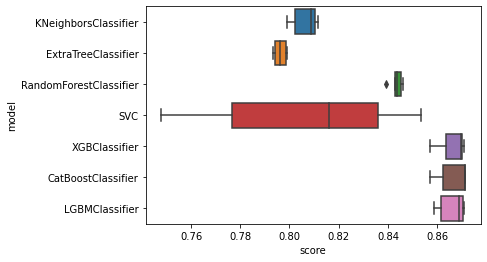

In [27]:
sns.boxplot(data=models_df, x='score', y='model')

Ostatnie trzy (XGBoost, LigthGBM i CatBoost) dają najlepsze wyniki i pewnie warto je brać pod uwagę w przyszłości.

A czy są różnice pomiędzy transformatorami?

<AxesSubplot:xlabel='score', ylabel='num_trans'>

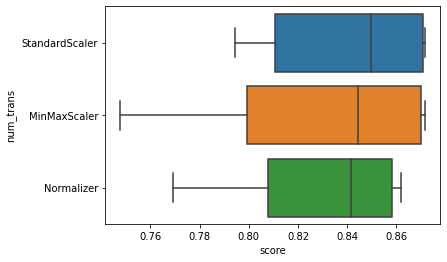

In [28]:
sns.boxplot(data=models_df, x='score', y='num_trans')

<AxesSubplot:xlabel='score', ylabel='cat_trans'>

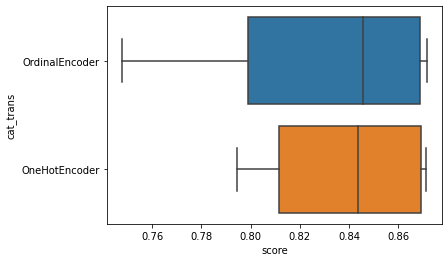

In [29]:
sns.boxplot(data=models_df, x='score', y='cat_trans')

Przy tych danych wygląda to tak, że właściwie nie ma większej różnicy. Może więc czas jest istotny?

<AxesSubplot:xlabel='time_elapsed', ylabel='model'>

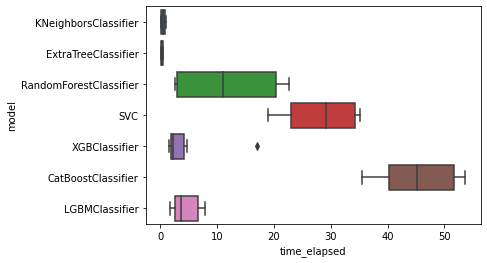

In [32]:
sns.boxplot(data=models_df, x='time_elapsed', y='model')

Mamy kilku liderów, ale z tych które dawały najlepsze wyniki warto wziąć pod uwagę XGBoosta i LightGMB.

Dzięki przećwiczeniu kilku modeli mamy dwóch najbardziej efektywnych (czasowo) i efektownych (z najlepszym *accuracy*) kandydatów do dalszych prac. Wyszukanie ich to kilka liniii kodu. Jeśli przyjdzie nam do głowy nowy model - dodajemy go do listy `classifiers`. Jeśli znajdziemy inny transformator - dopisujemy do listy `scalers` lub `cat_transformers`. Nie trzeba kopiować dużych kawałków kodu, nie trzeba właściwie pisać nowego kodu.

Dokładnie tym samym sposobem możemy poszukać *hyperparametrów* dla konkretnego zestawu w **pipeline**. Ale to już w następnym odcinku.

<AxesSubplot:xlabel='time_elapsed', ylabel='score'>

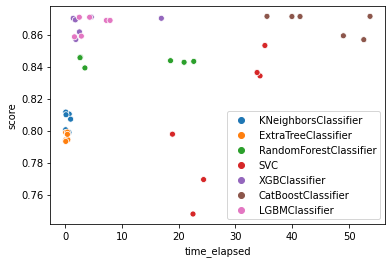

In [39]:
sns.scatterplot(data=models_df, x='time_elapsed', y='score', hue=models_df.model.to_list())

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__max_depth': [5], # [1, 3, 5, 10], 
    'classifier__min_child_weight': [0.5], # [0.25, 0.5, 0.75],
    'classifier__n_estimators': [250, 500], #[25, 50, 100, 250, 500], 
    'classifier__subsample': [0.8, 0.9], #[0.5, 0.75, 0.8],
    'classifier__learning_rate': [0.05, 0.075, 0.09, 0.1, 0.125, 0.15, 0.2] #[0.01, 0.1, 0.2, 0.3, 0.5, 0.75]
}

In [ ]:
pipe_scheme = Pipeline(steps=[
    ('preprocessor',
         ColumnTransformer(transformers=[
                                            ('numerical', StandardScaler(), cols_numerical),
                                            ('categorical', OrdinalEncoder(), cols_categorical)
                                        ])
    ),
    ('classifier', XGBClassifier())
])

In [ ]:
CV = GridSearchCV(pipe_scheme, param_grid, n_jobs=-1)

In [ ]:
CV.fit(X_train, y_train)

In [ ]:
print(CV.best_params_)    
print(CV.best_score_)

In [ ]:
sns.distplot(pd.DataFrame(CV.cv_results_)['mean_test_score'], bins=50)

In [ ]:
pd.DataFrame(CV.cv_results_).columns

In [ ]:
sns.boxplot(data=pd.DataFrame(CV.cv_results_), y = 'mean_test_score', x = 'param_classifier__learning_rate')

In [ ]:
sns.boxplot(data=pd.DataFrame(CV.cv_results_), y = 'mean_fit_time', x = 'param_classifier__n_estimators')